In [32]:
import <- function(pkg) { library(pkg, warn.conflicts=F, quietly=T, character.only=T) }
import("repr")
import("stringr")
import("tidyr")
import("dplyr")
import("ggplot2")
import("lme4")
import("emmeans")

In [33]:
options(repr.matrix.max.cols=15, repr.matrix.max.rows=20)
my.theme <- theme(legend.text=element_text(size=5),
                  legend.title=element_text(size=5),
                  plot.title = element_text(size=6, hjust=0.5),
                  axis.line=element_line(linewidth=0.25),
                  axis.ticks=element_line(linewidth=0.25),
                  axis.ticks.length=unit(0.05, "cm"),
                  axis.title=element_text(size=6),
                  axis.text=element_text(size=5),
                  strip.placement="outside",
                  strip.text=element_text(size=6),
                  strip.background=element_blank())
no.legend <- theme(legend.position="none")
update_geom_defaults("point", list(fill="white", shape=21, size=0.6))
update_geom_defaults("line", list(linewidth=0.25))


## Loading data and first steps of analysis

### Metadata

In [64]:
birds <- (
    data.table::fread("../inputs/bird_metadata.csv")
    |> mutate(age_group = cut(age, c(0,20,35,121), labels = (c('J18','J30','Adult'))))
)
sites <- data.table::fread("../inputs/recording_metadata.csv")
all_sites <- (
   sites
   |> mutate(bird=str_match(site, "[:alnum:]+")[,1])
   |> inner_join(birds, by="bird")
   |> filter(area %in% c("deep", "intermediate", "superficial"), stim_amplitude == "okay")
   |> filter(area =='deep')
   |> mutate(area=forcats::fct_recode(area, "L3/NCM"="deep") |> forcats::fct_relevel(c("L3/NCM")),
             group=factor(group, levels=c("CR", "PR")))
)


In [65]:
all_sites

site,hemisphere,area,stim_amplitude,bird,uuid,sex,group,age,sibling,age_group
<chr>,<chr>,<fct>,<chr>,<chr>,<chr>,<chr>,<fct>,<int>,<int>,<fct>
C31_1_1,L,L3/NCM,okay,C31,6d0caa42,M,PR,108,2,Adult
C31_2_1,L,L3/NCM,okay,C31,6d0caa42,M,PR,108,2,Adult
C41_1_1,L,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C41_2_1,L,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C41_3_1,L,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C41_6_1,R,L3/NCM,okay,C41,d8d22a36,M,PR,104,4,Adult
C44_3_1,L,L3/NCM,okay,C44,471dcc13,M,PR,111,4,Adult
C44_6_1,R,L3/NCM,okay,C44,471dcc13,M,PR,111,4,Adult
R229_2_1,L,L3/NCM,okay,R229,098832ed,F,PR,98,4,Adult


In [66]:
## number of animals in each condition by sex
(
    all_sites
    |> distinct(bird, sex, group)
    |> xtabs(~ sex + group, data=_)
    |> addmargins()
)

,CR,PR,Sum
F,2,1,3
M,2,3,5
U,1,0,1
Sum,5,4,9


In [67]:
## number of animals in each condition by age
(
    all_sites
    |> distinct(bird, age_group, group)
    |> xtabs(~ age_group + group, data=_)
    |> addmargins()
)

,CR,PR,Sum
J18,0,0,0
J30,1,0,1
Adult,4,4,8
Sum,5,4,9


In [68]:
## number of sites by area and condition
(
    all_sites
    |> xtabs(~ area + group, data=_)
    |> addmargins()
)

,CR,PR,Sum
L3/NCM,10,10,20
Sum,10,10,20


In [71]:
## birds per area/group#
(
    distinct(all_sites, area, bird, group) 
    |> xtabs(~ area + group, data=_)
)    

        group
area     CR PR
  L3/NCM  5  4

### Unit waveform classifications

Need to have run `python scripts/unit_waveforms.py -o build inputs/all_units.txt`

In [72]:
unit_spike_features <- (
    data.table::fread("../build/mean_spike_features.csv") %>%
    mutate(spike=factor(spike, levels=c("wide", "narrow"), exclude="")) %>%
    filter(!is.na(spike))
)

In [73]:
### generate tables of pr and cr units - this is used by the pooled decoder analysis
all_units <- (
    unit_spike_features %>%
    mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1]) %>%
    select(unit, site) %>%
    left_join(all_sites, by="site")
)
filter(all_units, group=="CR") %>% select(unit) %>% readr::write_csv("../build/cr_units.txt", col_names=F)
filter(all_units, group=="PR") %>% select(unit) %>% readr::write_csv("../build/pr_units.txt", col_names=F)

In [74]:
## number of units by area and condition
(
    all_units
    |> xtabs(~ area + group + age_group, data=_)
    |> addmargins()
)

, , age_group = J18

        group
area      CR  PR Sum
  L3/NCM   0   0   0
  Sum      0   0   0

, , age_group = J30

        group
area      CR  PR Sum
  L3/NCM  55   0  55
  Sum     55   0  55

, , age_group = Adult

        group
area      CR  PR Sum
  L3/NCM 568 283 851
  Sum    568 283 851

, , age_group = Sum

        group
area      CR  PR Sum
  L3/NCM 623 283 906
  Sum    623 283 906


### Discriminability

Discriminability is assessed by computing spike distances and training a classifier. The computation is performed by `scripts/motif_discrim.py`.

We classify cells as responsive if the z-score of the cross-validation is above the one-tailed 95% confidence level.

In [75]:
z_score_alpha <- 0.05
z_score_global_thresh <- qnorm(1 - z_score_alpha)
## this is not used: too easy for individual motifs to sneak over the threshold
z_score_motif_thresh <- qnorm(1 - z_score_alpha/9)

In [76]:
header <- data.table::fread(cmd='find ../build/ -name "*motif_discrim.csv" | head -n1 | xargs head -n1', header=T)
motif_discrim <- tibble(data.table::fread(cmd='find ../build/ -name "*motif_discrim.csv" | xargs tail -q -n+2', header=F))
names(motif_discrim) <- names(header)

In [77]:
unit_n_discrim <- (
    motif_discrim
    %>% filter(foreground!="_average")
    %>% group_by(unit)
    %>% summarize(n_discrim=sum(z_score > z_score_motif_thresh), max_score=max(score))
)

In [78]:
unit_n_discrim

unit,n_discrim,max_score
<chr>,<int>,<dbl>
C104_1_1_c10,5,0.7
C104_1_1_c109,1,0.4
C104_1_1_c11,1,0.5
C104_1_1_c112,5,0.8
C104_1_1_c118,0,0.3
C104_1_1_c119,0,0.3
C104_1_1_c120,0,0.3
C104_1_1_c124,6,0.7
C104_1_1_c127,0,0.3


In [79]:
## classify units as auditory at each noise level and join to metadata
unit_discrim <- (
    motif_discrim
    %>% filter(foreground=="_average")
    %>% select(!foreground)
    %>% inner_join(unit_n_discrim, by="unit")
    %>% mutate(is_auditory=(z_score > z_score_global_thresh))
    %>% inner_join(select(unit_spike_features, unit, spike), by="unit")
    %>% mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
)

In [80]:
unit_discrim

unit,score,z_score,spikes_mean,nonzero_trials,n_discrim,max_score,is_auditory,spike,site
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<lgl>,<fct>,<chr>
C44_6_1_c135,0.38888889,9.0361751,9.1333333,9.444444,5,0.7,TRUE,narrow,C44_6_1
C60_2_1_c158,0.06666667,-0.7170856,0.1222222,1.111111,0,0.2,FALSE,wide,C60_2_1
C24_1_1_c227,0.82222222,21.2844648,52.3666667,10.000000,9,1.0,TRUE,narrow,C24_1_1
C104_3_1_c126,0.05555556,-1.1623203,0.6000000,3.777778,0,0.2,FALSE,wide,C104_3_1
b01e6518_2_1_c72,0.15555556,1.8934997,2.8888889,8.777778,0,0.4,TRUE,wide,b01e6518_2_1
C105_3_1_c114,0.14444444,1.6089149,0.9333333,6.666667,1,0.6,FALSE,wide,C105_3_1
C194_2_1_c19,0.16666667,2.2549650,3.2888889,8.555556,1,0.4,TRUE,wide,C194_2_1
C105_1_1_c221,0.14444444,1.7212198,0.2111111,1.777778,1,0.4,TRUE,narrow,C105_1_1
C41_1_1_c241,0.13333333,1.3298171,1.0222222,6.555556,0,0.3,FALSE,wide,C41_1_1


In [81]:
## save output for downstream analysis
filter(unit_discrim, is_auditory) |> ungroup() |> select(unit) |> write.table("../inputs/responsive_units.txt", quote=F, row.names=F, col.names=F)

In [ ]:
## this code cell is for picking out examples. It can be hard to find units that are selective but not too selective.
(
    unit_discrim
    |> inner_join(all_sites, by="site")
    |> filter(area=="L3/NCM", spike=="wide", str_starts(unit, "C104_3_1"), is_auditory)
    |> arrange(spikes_mean)
)

### Firing rates

Firing rates can be summarized across trials by adding up the number of events and the total observation interval. The underlying assumption
is that the spike counts have a poisson distribution, which is probably not true but better than the alternative of assuming the rates are normally distributed.

In [82]:
header <- data.table::fread(cmd='find ../build/ -name "*_rates.csv" | head -n1 | xargs head -n1', header=T)
motif_rates <- tibble(data.table::fread(cmd='find ../build/ -name "*_rates.csv" | xargs tail -q -n+2', header=F))
names(motif_rates) <- names(header)
motif_rates <- (
    motif_rates
    |> filter(background_dBFS==-100 | foreground=="silence", foreground!="background")
    |> mutate(foreground=relevel(factor(foreground), "silence"))
)
motif_rate_summary <- (
    motif_rates
    |> group_by(unit, foreground) 
    |> summarize(n_events=sum(n_events), interval=sum(interval_end))
    ## this regularizes rate estimates for silence by adding 1 spike to units with no spontaneous spikes
    |> mutate(n_events=ifelse(foreground=="silence" & n_events == 0, 1, n_events))
)

`summarise()` has grouped output by 'unit'. You can override using the
`.groups` argument.


Compute some unit-level rate statistics:

1. `n_responsive` - the number of stimuli that evoked a significant change in firing rate relative to silence. Significance is assessed using a Poisson GLM.
2. `activity_frac` - the Vinje and Gallant activity fraction across all non-silence stimuli


In [83]:
## compute unit-level rate statistics
rate_model <- function(df) {
    glm(n_events ~ foreground, data=df, offset=log(interval), family=poisson)
}

response_strength <- function(df) {
    df <- mutate(df, rate=n_events / interval)
    spont <- df$rate[df$foreground == "silence"]
    filter(df, foreground != "silence") |> transmute(rate, rs=rate - spont, zscore=rs / sd(rate))
}

activity_fraction <- function(df) {
    df |> filter(foreground!="silence") |> mutate(rate=n_events / interval) |> summarize(activity_frac=(1 - sum(rate / n())**2 / sum(rate**2 / n())) / (1 - 1 / n()))
}

rate_model_responsive <- function(mdl) {
    (
        emmeans(mdl, ~ foreground) 
        |> contrast("trt.vs.ctrl") 
        |> broom::tidy() 
        |> transmute(foreground=str_extract(contrast, "\\w+"), estimate, is_responsive=(estimate > 0) & (adj.p.value < 0.05))
    )
}

In [84]:
(
    motif_rate_summary
    |> filter(unit=="b01e6518_2_1_c72")
    |> rate_model()
    |> emmeans(~ foreground)
    |> contrast("trt.vs.ctrl")
    |> broom::tidy()
)

term,contrast,null.value,estimate,std.error,df,statistic,adj.p.value
<chr>,<chr>,"<dbl[,1]>",<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
foreground,0oq8ifcb - silence,0,0.5975424,0.2653454,Inf,2.251942,1.665767e-01
foreground,9ex2k0dy - silence,0,0.6602820,0.2608203,Inf,2.531560,8.615428e-02
foreground,c95zqjxq - silence,0,1.1392478,0.2232038,Inf,5.104070,3.303383e-06
foreground,g29wxi4q - silence,0,0.3285910,0.2879378,Inf,1.141187,8.007769e-01
foreground,igmi8fxa - silence,0,0.6880610,0.2814812,Inf,2.444429,1.069291e-01
foreground,jkexyrd5 - silence,0,1.3526569,0.2064713,Inf,6.551308,5.702059e-10
foreground,l1a3ltpy - silence,0,1.1177999,0.2145907,Inf,5.208985,1.888961e-06
foreground,p1mrfhop - silence,0,0.7057193,0.2426308,Inf,2.908614,3.043043e-02
foreground,vekibwgj - silence,0,0.7129564,0.2608203,Inf,2.733516,5.038750e-02


In [85]:
# this cell takes a long time to run - it would be nice to do this in motif_rates.py but I can't do marginal means in python
unit_motif_responsive <- (
    motif_rate_summary
    |> group_by(unit)
    |> nest()
    |> mutate(rate_stats=purrr::map(data, response_strength))
    |> mutate(model=purrr::map(data, rate_model))
    |> mutate(responsive=purrr::map(model, rate_model_responsive))
    |> select(unit, responsive, rate_stats)
    |> unnest(cols=c(responsive, rate_stats))
)

In [86]:
unit_rate_stats <- (
    unit_motif_responsive
    |> group_by(unit)
    |> summarize(avg_evoked=mean(estimate), n_responsive=sum(is_responsive), activity_frac=(1 - sum(rate / n())**2 / sum(rate**2 / n())) / (1 - 1 / n()))
)

Join the rate and discrimination data together with metadata.

In [87]:
unit_summary <- (
    unit_discrim
    |> inner_join(unit_rate_stats, by="unit")
    |> inner_join(all_sites, by="site")
)

site_summary <- (
    unit_summary
    |> group_by(bird, site, sex, group, area, spike)
    |> summarize(n_units=n(), n_auditory=sum(is_auditory), n_auditory_rate=sum(n_responsive > 0))
)

unit_motif_summary <- (
    motif_rate_summary
    |> inner_join(select(unit_spike_features, unit, spike), by="unit")
    |> mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
    |> inner_join(all_sites, by="site")
)

`summarise()` has grouped output by 'bird', 'site', 'sex', 'group', 'area'. You
can override using the `.groups` argument.


In [88]:
site_summary

bird,site,sex,group,area,spike,n_units,n_auditory,n_auditory_rate
<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<int>,<int>,<int>
C104,C104_1_1,F,CR,L3/NCM,wide,50,12,15
C104,C104_1_1,F,CR,L3/NCM,narrow,16,15,8
C104,C104_2_1,F,CR,L3/NCM,wide,9,2,0
C104,C104_2_1,F,CR,L3/NCM,narrow,1,0,0
C104,C104_3_1,F,CR,L3/NCM,wide,80,31,20
C104,C104_3_1,F,CR,L3/NCM,narrow,20,16,11
C194,C194_2_1,M,CR,L3/NCM,wide,105,43,35
C194,C194_2_1,M,CR,L3/NCM,narrow,14,12,11
C195,C195_1_1,M,CR,L3/NCM,wide,64,14,18


In [89]:
# save for plotting elsewhere
unit_motif_responsive |> write.csv("../build/motif_rate_coefs.csv", quote=F, row.names=F)

## Example units

In [ ]:
(
    unit_summary
    |> filter(area=="L3/NCM", spike=="narrow", is_auditory)
    |> arrange(n_responsive)
    |> select(unit, score, spikes_mean, nonzero_trials, n_discrim, activity_frac, n_responsive)
    |> filter(score < 1, n_discrim==8)
    |> arrange(score)
)

## Single-Unit statistics

### Number of units per site

Supplementary

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p3.1 <- (
    site_summary
    |> ggplot(aes(spike, n_units, fill=group))
    + facet_wrap(~ area)
    + geom_boxplot(width=0.5, outlier.size=1)
    + scale_y_log10(name="total units per site")
    + scale_x_discrete(name="spike shape")
)
p3.1 + theme_classic() + my.theme

In [ ]:
# GLMM
fm_units <- glmer(n_units ~ area*spike*group + (1 + spike|site), site_summary, control=glmerControl(optimizer="bobyqa"), family=poisson)
emmeans(fm_units, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_units
    |> emmeans(~ group*spike*area)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(area, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="total units per site")
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/total_units_per_site.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Spontaneous firing rate

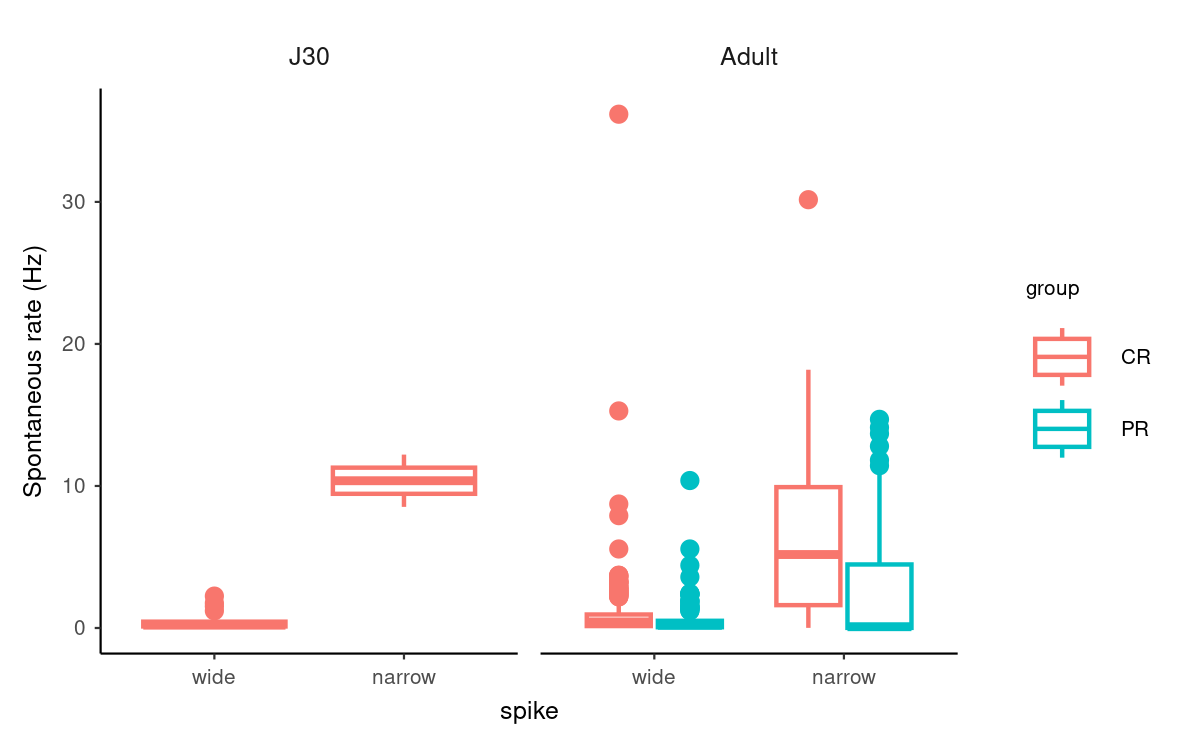

In [90]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_motif_summary
    |> filter(foreground=="silence")
    |> mutate(rate=mean(n_events / interval))
    |> ggplot(aes(spike, rate, color=group))
    + facet_wrap(~ age_group)
    + geom_boxplot()
    + scale_y_continuous(name="Spontaneous rate (Hz)")
)
p + theme_classic() + my.theme

In [92]:
fm_spont <- glmer(
    n_events ~ age_group*spike*group + (1|unit),
    offset=log(interval),
    family=poisson,
    control=glmerControl(optimizer = "bobyqa"),
    data=unit_motif_summary |> filter(foreground=="silence")
)

fixed-effect model matrix is rank deficient so dropping 2 columns / coefficients



In [93]:
(
    fm_spont
    |> emmeans(~ group | age_group*spike)
    |> contrast("pairwise")
)

age_group = J30, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    nonEst    NA  NA      NA      NA

age_group = Adult, spike = wide:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     0.731 0.139 Inf   5.272  <.0001

age_group = J30, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR    nonEst    NA  NA      NA      NA

age_group = Adult, spike = narrow:
 contrast estimate    SE  df z.ratio p.value
 CR - PR     2.512 0.246 Inf  10.197  <.0001

Results are given on the log (not the response) scale. 

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”
Warning message:
“Removed 1 row containing missing values or values outside the scale range
(`geom_segment()`).”


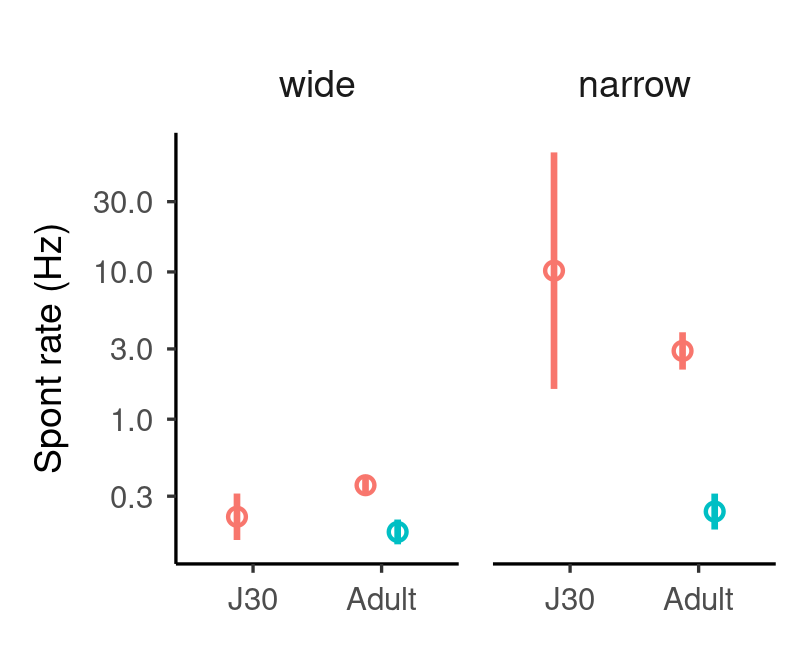

In [95]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_spont
    |> emmeans(~ group*spike*age_group, type="response", offset=0)
    |> confint(level=0.90)
    |> ggplot(aes(age_group, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="Spont rate (Hz)")
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/spont_rate_all_units.pdf", width=1.8, height=1.5)
print(p)
dev.off()

### Evoked rate

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_motif_summary
    |> filter(foreground!="silence")
    |> mutate(rate=mean(n_events / interval))
    |> group_by(group, area, spike, unit)
    |> summarize(rate=mean(rate))
    |> ggplot(aes(area, rate, color=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + scale_y_log10(name="Evoked rate (Hz)")
    + theme_classic() + my.theme
)
p 

In [ ]:
fm_evoked <- glmer(
    n_events ~ group*area*spike + (1|unit),
    offset=log(interval),
    family=poisson,
    control=glmerControl(optimizer="bobyqa"),
    data=unit_motif_summary |> filter(foreground!="silence")
)

In [ ]:
(
    fm_evoked
    |> emmeans(~ group | area*spike)
    |> contrast("pairwise")
)

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_evoked
    |> emmeans(~ group*spike*area, type="response", offset=0)
    |> confint(level=0.90)
    |> ggplot(aes(area, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="Evoked rate (Hz)")
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/evoked_rate_all_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Discriminability

Discriminability is what we use to decide whether neurons are auditory or not, so any trends need to be analyzed using all neurons.

In [ ]:
## raw classifier scores
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> ggplot(aes(area, score, fill=group))
    + facet_wrap(~ spike)
    + geom_violin()
    + my.theme
)
p 

In [ ]:
## GLMM
## There are 90 comparisons for each trial, so score can be converted to a binomial RV by multiplying by 90
fm_discrim_score <- (
    unit_summary 
    |> mutate(n_correct=score * 90)
    |> glmer(cbind(n_correct, 90 - n_correct) ~ group*area*spike + (1|unit), 
             data=_, 
             control=glmerControl(optimizer="bobyqa"), 
             family=binomial)
)
emmeans(fm_discrim_score, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_discrim_score
    |> emmeans(~ group*spike*area, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(area, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="Discriminability", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/discriminability_all_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

In [ ]:
## number of discriminable motifs
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> ggplot(aes(area, n_discrim/10, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + theme_classic() + my.theme + no.legend
)
p + my.theme

In [ ]:
## GLMM
## Alternatively, how many motifs are discriminable
fm_discrim_n <- (
    unit_summary
    |> glmer(cbind(n_discrim, 9 - n_discrim) ~ group*area*spike + (1|unit), data=_, control=glmerControl(optimizer="bobyqa"), family=binomial)
)
emmeans(fm_discrim_n, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_discrim_n
    |> emmeans(~ group*spike*area, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(area, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="p(discriminable)", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/p_discriminable_all_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Number of auditory units per site

Supplementary

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    site_summary
    |> ggplot(aes(area, n_auditory, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + my.theme
)

In [ ]:
(
    site_summary
    |> ggplot(aes(area, n_auditory_rate, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + my.theme
)

In [ ]:
# GLMM
fm_aud_units <- glmer(n_auditory ~ group*area*spike + (1 + spike|site), site_summary, control=glmerControl(optimizer="bobyqa"), family=poisson)
emmeans(fm_aud_units, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_aud_units
    |> emmeans(~ group*spike*area)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(area, rate, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_log10(name="auditory units per site")
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/aud_units_per_site.pdf", width=1.8, height=1.45)
print(p)
dev.off()

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    site_summary
    |> ggplot(aes(area, n_auditory / n_units, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + scale_y_continuous(name="p(responsive)", limits=c(0, 1))
    + my.theme
)

In [ ]:
fm_aud_prop <- glmer(
    cbind(n_auditory, n_units - n_auditory) ~ group*area*spike + (1 + spike|site), 
    site_summary,
    control=glmerControl(optimizer="bobyqa"),
    family=binomial)
emmeans(fm_aud_prop, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_aud_prop
    |> emmeans(~ group*spike*area)
    |> confint(level=0.90, type="response")
    |> ggplot(aes(area, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="p(auditory)", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p

In [ ]:
pdf("../figures/aud_units_proportion_site.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Selectivity (auditory units only)

A very simple definition of selectivity is related to what proportion of stimuli evoke a significant response.

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> filter(is_auditory)
    |> ggplot(aes(area, 1 - n_responsive/10, fill=group))
    + facet_wrap(~ spike)
    + geom_violin()
)
p + my.theme

In [ ]:
## GLMM
fm_selectivity <- (
    unit_summary 
    |> filter(is_auditory)
    |> glmer(
        cbind(10 - n_responsive, n_responsive) ~ group*area*spike + (1|unit), 
        data=_,
        control=glmerControl(optimizer="bobyqa"),
        family=binomial)
)
emmeans(fm_selectivity, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_selectivity
    |> emmeans(~ group*spike*area, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(area, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="Selectivity", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/selectivity_auditory_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

### Selectivity - activity fraction

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
p <- (
    unit_summary
    |> filter(is_auditory)
    |> ggplot(aes(area, activity_frac, fill=group))
    + facet_wrap(~ spike)
    + geom_boxplot()
    + my.theme
)
p

In [ ]:
## LMM
fm_selectivity <- lmer(
    activity_frac ~ group*area*spike + (1|site), 
    data=unit_summary |> filter(is_auditory))
emmeans(fm_selectivity, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=2.6, repr.plot.height=2.6, repr.plot.res = 450)
(
    unit_summary
    |> filter(is_auditory)
    |> ggplot(aes(score, 1 - n_discrim/10, color=group))
    + facet_grid(area ~ spike)
    + geom_point(alpha=0.4)
    #+ stat_smooth(method="lm", linewidth=0.5)
    + scale_x_continuous("Discriminability", limits=c(0,1))
    + scale_y_continuous("Selectivity", limits=c(0, 1))
    + theme_classic() + my.theme + no.legend
)

## Population sparseness

This is a quick and dirty way to look at sparseness, by calculating the proportion of units in a site that give significant responses to each motif.

In [ ]:
(
    unit_motif_responsive
    |> semi_join(filter(unit_discrim, is_auditory), by="unit")
    |> group_by(unit)
    |> arrange(desc(rate))
)

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
site_n_responsive <- (
    unit_motif_responsive
    # only auditory units?
    |> semi_join(filter(unit_discrim, is_auditory), by="unit")
    |> inner_join(select(unit_spike_features, unit, spike), by="unit")
    |> mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
    |> inner_join(all_sites, by="site")
    |> group_by(bird, group, area, spike, site, foreground)
    |> summarize(n_units=n(), n_responsive=sum(is_responsive))
)

In [ ]:
options(repr.plot.width=4, repr.plot.height=2.5, repr.plot.res = 300)
(
    site_n_responsive
    |> summarize(sparseness= 1 - mean(n_responsive) / mean(n_units))
    |> ggplot(aes(area, sparseness, fill=group))
    + facet_grid(~ spike)
    + geom_boxplot() # stat_summary(fun.data="mean_se")
    + theme_classic() + my.theme
)

In [ ]:
## GLMM
fm_sparseness <- glmer(
    cbind(n_units - n_responsive, n_responsive) ~ group*area*spike + (1 + area|bird),
    data=site_n_responsive,
    control=glmerControl(optimizer="bobyqa"),
    family=binomial)
emmeans(fm_sparseness, ~ group | area*spike) |> contrast("pairwise")

In [ ]:
options(repr.plot.width=1.8, repr.plot.height=1.45, repr.plot.res = 450)
p <- (
    fm_sparseness
    |> emmeans(~ group*spike*area, type="response")
    |> confint(level=0.90)
    |> ggplot(aes(area, prob, color=group))
    + facet_wrap(~ spike)
    + geom_point(position=position_dodge(width=0.5), size=1)
    + geom_linerange(aes(ymin=asymp.LCL, ymax=asymp.UCL), position=position_dodge(width=0.5))
    + scale_x_discrete(name=NULL)
    + scale_y_continuous(name="Sparseness", limits=c(0,1))
    + theme_classic() + my.theme + no.legend
)
p 

In [ ]:
pdf("../figures/sparseness_auditory_units.pdf", width=1.8, height=1.45)
print(p)
dev.off()

In [ ]:
cr_wide <- (
    unit_motif_responsive
    |> inner_join(select(unit_spike_features, unit, spike), by="unit")
    |> mutate(site=str_match(unit, "[:alnum:]+_\\d+_\\d+")[,1])
    |> inner_join(all_sites, by="site")
    |> filter(group=="PR") #, spike=="narrow", area=="L3/NCM")
)

In [ ]:
cr_wide_best_stim <- (
    cr_wide
    |> group_by(unit)
    |> summarize(best_stim=foreground[which.max(estimate)], max_resp=max(estimate), selectivity=1 - mean(is_responsive))
    |> arrange(best_stim, selectivity, max_resp)
    # |> filter(selectivity < 1)
    |> mutate(idx=row_number())    
)
cr_wide_best_stim

### Principal components

Another approach to measuring sparseness is to use principal components analysis to estimate the degree to which neural responses are correlated across stimulus conditions. The responses are organized into a conditions x neurons array. The principal components (row vectors) correspond to groups of neurons that covary. A sparse code should be characterized by a relatively flat eigenspectrum.

In [ ]:
(
    cr_wide
    |> inner_join(cr_wide_best_stim, by="unit")
    |> ggplot(aes(foreground, idx))
    + geom_tile(mapping=aes(fill=zscore))
    + scale_fill_gradient2()
    + theme(axis.ticks.x=element_blank(), axis.text.x=element_blank(), axis.ticks.y=element_blank(), axis.text.y=element_blank())
)

In [ ]:
options(repr.plot.width=3, repr.plot.height=3, repr.plot.res = 300)
pca <- (
    cr_wide
    |> pivot_wider(id_cols=unit, names_from=foreground, values_from=zscore)
    |> ungroup()
    |> select(-unit)
    |> as.matrix()
    |> t()
    |> prcomp()
)
plot(pca)

In [ ]:
options(repr.plot.width=3, repr.plot.height=3, repr.plot.res = 300)
pca <- (
    cr_wide
    |> pivot_wider(id_cols=unit, names_from=foreground, values_from=zscore)
    |> ungroup()
    |> select(-unit)
    |> as.matrix()
    |> t()
    |> prcomp()
)
plot(pca)

## Noise invariance

Just seeing if there is anything worth reporting in this paper.

In [ ]:
(
    unit_level_discrim
    |> inner_join(all_sites, by="site")
    |> ggplot(aes(background_dBFS, score))
    + facet_grid(spike ~ area)
    + stat_summary(aes(color=group))
    + geom_line(mapping=aes(color=group, group=unit), alpha=0.1)
    + theme_classic() + my.theme
)